In [0]:
# Packages for analysis
import pandas as pd
import numpy as np
from sklearn import svm
import zipfile

# Packages for visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)

# Allows charts to appear in the notebook
%matplotlib inline

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1UROh3KB6OO1VL96mRHo53bN5q3kPI8tU'
fluff, id = link.split('=')

As a dataset for multiclass classification the following data were chosen:
https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey

because
 - the dataset has a number of interesting parameters to explore;
 - the quality of the data is high;
 - the size of the dataset suggests that we can hope for high accuracy. 
 
 And it is about cosmic bodies, so it is quite romantic to explore! 

 So, **our goal** here is to classify celestial objects by types (stars, galaxies and quasars).

In [64]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Skyserver_SQL2_27_2018 6_51_39 PM.csv.zip') 
zf = zipfile.ZipFile('Skyserver_SQL2_27_2018 6_51_39 PM.csv.zip') 
start_data = pd.read_csv(zf.open('Skyserver_SQL2_27_2018 6_51_39 PM.csv')) 
start_data.rename(columns={"class": "typeobj"}, inplace = True)
start_data["typeobjid"] = start_data["typeobj"].factorize()[0]
start_data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,typeobj,redshift,plate,mjd,fiberid,typeobjid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491,0
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541,0
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513,1
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510,0
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512,0


**Content**

The data consists of 10,000 observations of space taken by the Sloan Digital Sky Survey (SDSS). Every observation is described by 17 feature columns and 1 class column ("typeobj") which identifies it to be either a star, galaxy or quasar. When downloading the dataset, we also added "typeobjid" column which shows numeric values that correspond to the type of the object: 0 for STAR, 1 for GALAXY, 2 for QUASAR.


**Basic Feature Description**

In the represented dataset we have  **photometric  measurements**:



> Right ascension (abbreviated *ra*) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated *dec*), these astronomical coordinates specify the direction of a point on the celestial sphere in the equatorial coordinate system.


And **spectral data**:


> *u, g, r, i, z* abbreviations stand for five filters used on the telescope. Each filter is designed to let in light around a specific wavelength. The filters work by blocking out light at all wavelengths except those around the wavelength they are designed to see.

- *u* for ultraviolet
- *g* for green
- *r* for red
- *i* for Near infrared
- *z* for Infrared

We are also provided with data relating to the details about processed images (*run, rereun, camcol, field*), but we will not use it as it has little to do with the type of the object.



# Picking usefull parameters for classification

From the scatter plot of the astronomical coordinates of the objects, it can easily be seen that they are clustered together, what makes these data useless in our effort to classify the objects by type. Yet, this is logical --- the space does not differ much in content in different directions. 

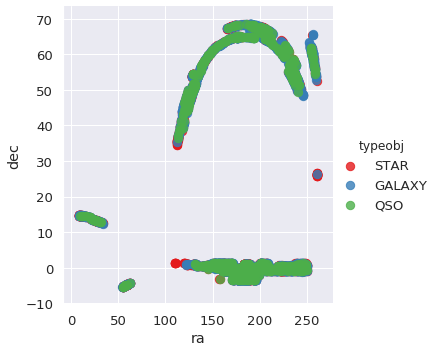

In [65]:
sns.lmplot('ra', 'dec', data=start_data, hue='typeobj',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70});

We will build pair plots of the spectral data, redshift values and the type of the object to find some dependencies or trends.

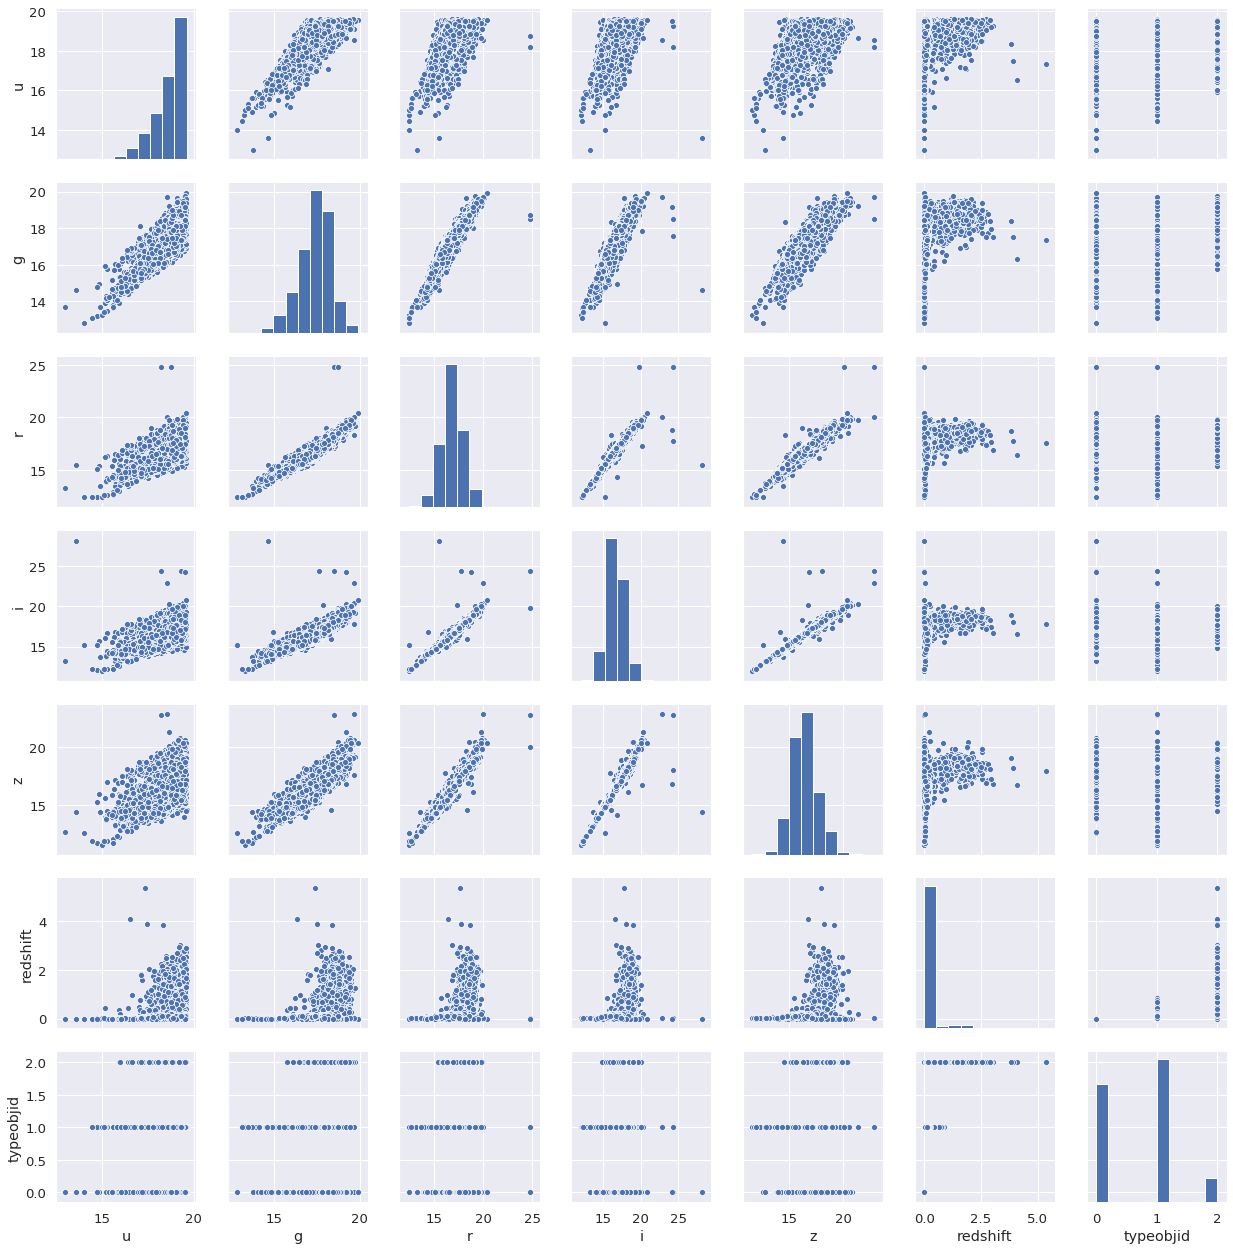

In [66]:
sns.pairplot(start_data[['u','g','r','i','z','redshift','typeobjid']])

# Support Vector Machine 

We apply the Support Vector Machine (SVM) method from the `sklearn` package. To do so, we've picked a dataframe with spectral measurements as well as redshift values to create a pool of classification features. 

In [67]:
X = start_data[['u','g','r','i','z','redshift']].as_matrix()
y = start_data.typeobjid

#splitting the data we have into two sets: a training one, a testing one (will take 20% of the original data)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


To tune our classifier, we used Grid Search, which allows to find optimal parameters of our model. 

> Low C parameter prioritizes simplicity of the model and soft margins, while high values of C prioritize making as few mistakes in predictions as possible.

> Gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'.

In the classification, we tried applying two types of kernels: "linear" and "radial basis function" ("rbf"). The choice of a kernel determines the type of a hyperplane used to split data. 

# Linear Kernel

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001,], 
              'kernel': ['linear']}  

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] ..... C=0.001, gamma=1, kernel=linear, score=0.756, total=   1.1s
[CV] C=0.001, gamma=1, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ..... C=0.001, gamma=1, kernel=linear, score=0.754, total=   0.8s
[CV] C=0.001, gamma=1, kernel=linear .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV] ..... C=0.001, gamma=1, kernel=linear, score=0.772, total=   0.9s
[CV] C=0.001, gamma=0.1, kernel=linear ...............................
[CV] ... C=0.001, gamma=0.1, kernel=linear, score=0.756, total=   0.8s
[CV] C=0.001, gamma=0.1, kernel=linear ...............................
[CV] ... C=0.001, gamma=0.1, kernel=linear, score=0.754, total=   0.8s
[CV] C=0.001, gamma=0.1, kernel=linear ...............................
[CV] ... C=0.001, gamma=0.1, kernel=linear, score=0.772, total=   0.8s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV] .. C=0.001, gamma=0.01, kernel=linear, score=0.756, total=   0.9s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV] .. C=0.001, gamma=0.01, kernel=linear, score=0.754, total=   0.8s
[CV] C=0.001, gamma=0.01, kernel=linear ..............................
[CV] .. C=0.001, gamma=0.01, kernel=linear, score=0.772, total=   0.8s
[CV] C=0.001, gamma=0.001, kernel=linear .............................
[CV] .

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [69]:
model = svm.SVC(kernel='linear', C=100, gamma=1e-05)
model.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
model.score(X_test, y_test)

0.989

In [0]:
y_pred = model.predict(X_test)

# Confusion Matrix

In [72]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[853   0   0]
 [ 11 950   3]
 [  1   7 175]]


Text(63.5, 0.5, 'Truth')

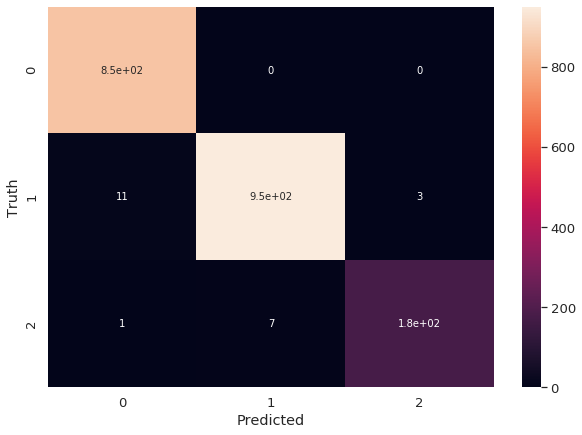

In [73]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# RBF Kernel

In [74]:
X = start_data[['u','g','r','i','redshift']].as_matrix()
y = start_data.typeobjid

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001,], 
              'kernel': ['rbf']}  

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.504, total=   1.7s
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.504, total=   1.6s
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.504, total=   1.6s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=0.001, gamma=0.1, kernel=rbf, score=0.504, total=   1.7s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=0.001, gamma=0.1, kernel=rbf, score=0.504, total=   1.6s
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV] ...... C=0.001, gamma=0.1, kernel=rbf, score=0.504, total=   1.6s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.504, total=   1.6s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.504, total=   1.6s
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV] ..... C=0.001, gamma=0.01, kernel=rbf, score=0.504, total=   1.6s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [75]:
modelrbf = svm.SVC(kernel='rbf', C=100, gamma=0.1)
modelrbf.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [76]:
modelrbf.score(X_test, y_test)

0.982

In [0]:
y_predrbf = modelrbf.predict(X_test)

# Confusion Matrix

In [78]:
from sklearn.metrics import classification_report, confusion_matrix
cmrbf = confusion_matrix(y_test,y_predrbf)
print(cmrbf)

[[859   1   0]
 [ 22 939   4]
 [  0   9 166]]


Text(63.5, 0.5, 'Truth')

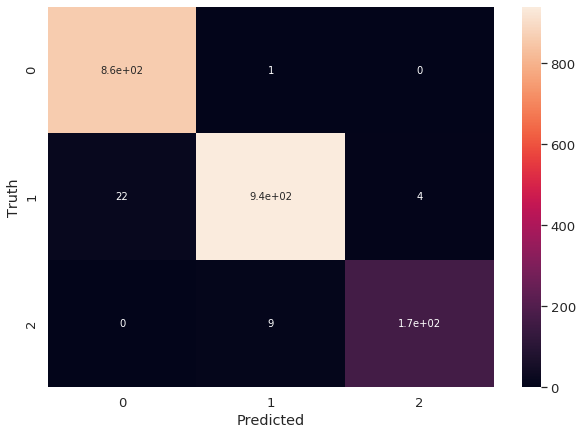

In [79]:
plt.figure(figsize=(10,7))
sns.heatmap(cmrbf, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Dimensionality Reduction Methods

As we have a number of features to concider in the classification, it might be usefull to use Dimensionality Reduction Methods to visualize the data in two dimentions. Here, we apply **Isomap** (Isometric Feature Mapping), which is a non-linear feature reduction method.

In [0]:
from sklearn import manifold
from sklearn.preprocessing import StandardScaler

iso = manifold.Isomap(n_neighbors=10, n_components=2)
X_stand = StandardScaler().fit_transform(X)
iso.fit(X_stand)
manifold_2Da = iso.transform(X_stand)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])

# Left with 2 dimensions
manifold_2D.head()

In [0]:
final_iso = pd.concat([manifold_2D, y], axis = 1)

In [0]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component isomap', fontsize = 20)
targets = ['STAR', 'GALAXY', 'QSO']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_iso['typeobj'] == target
    ax.scatter( final_iso.loc[indicesToKeep, 'Component 1']
               ,  final_iso.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

---
**Principal Component Analysis** (PCA) is fundamentally a dimensionality reduction  algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more. Unlike Isomap it is a linear method. 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_stand)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal Component 1', 'Principal Component 2'])

In [0]:
final_pca = pd.concat([principalDf, y], axis = 1)

In [0]:
figpca = plt.figure(figsize = (8,8))
axpca = figpca.add_subplot(1,1,1) 
axpca.set_xlabel('Principal Component 1', fontsize = 15)
axpca.set_ylabel('Principal Component 2', fontsize = 15)
axpca.set_title('2 component PCA', fontsize = 20)
targets = ['STAR', 'GALAXY', 'QSO']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_pca['typeobj'] == target
    axpca.scatter( final_pca.loc[indicesToKeep, 'Principal Component 1']
               ,  final_pca.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
axpca.legend(targets)
axpca.grid()